In [1]:
import cv2
import PIL
import numpy as np
import glob
import os
import micasense.capture as capture
import micasense
%matplotlib inline


In [2]:
imageDir="mydata/002/"
outputDir="mydata/results_002/"
imagePaths=glob.glob(imageDir+"*.tif")

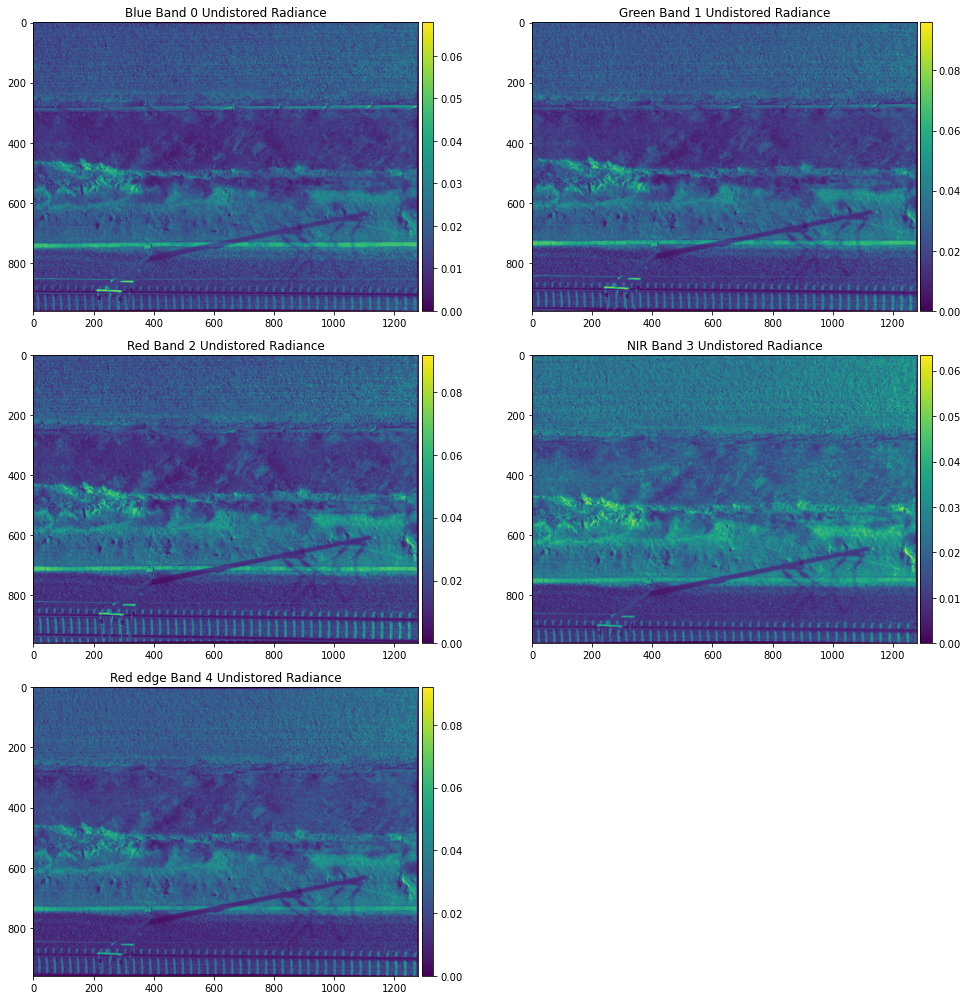

In [3]:
imageNumbers=[imagePath.split("_")[2] for imagePath in imagePaths]
unique_imgs=list(set([imagePath.replace(imageNumber,"") for imagePath, imageNumber in zip(imagePaths, imageNumbers)]))
unique_imgs.sort()
imageNames=glob.glob(unique_imgs[150]+"*")
panelNames = None

if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

myCapture = capture.Capture.from_filelist(imageNames)

for img in myCapture.images:
    if img.rig_relatives is None:
        raise ValueError("Images must have RigRelatives tags set which requires updated firmware and calibration. See the links in text above")

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
    myCapture.plot_undistorted_reflectance(panel_irradiance)
else:
    if False: #capture.dls_present():
        img_type='reflectance'
        myCapture.plot_undistorted_reflectance(capture.dls_irradiance())
    else:
        img_type = "radiance"
        myCapture.plot_undistorted_radiance()    

# Fast but not so good alignment

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

warp_mode = cv2.MOTION_HOMOGRAPHY
warp_matrices = myCapture.get_warp_matrices()

cropped_dimensions,edges = imageutils.find_crop_bounds(myCapture,warp_matrices)
im_aligned = imageutils.aligned_capture(myCapture, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)

print("warp_matrices={}".format(warp_matrices))

warp_matrices=[array([[ 1.01399300e+00,  7.25886437e-04, -2.93720124e+01],
       [ 9.11911147e-04,  1.01022559e+00,  1.85425730e+00],
       [ 4.83228671e-06, -1.17497481e-06,  1.00000000e+00]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[ 1.01006635e+00, -5.43579858e-04, -2.28546071e+01],
       [-1.57048950e-04,  1.01154956e+00, -2.68369256e+01],
       [-1.88461028e-06,  2.89858387e-07,  1.00000000e+00]]), array([[ 1.01541280e+00, -1.62106446e-05, -2.30427306e+01],
       [ 1.19329132e-03,  1.01419658e+00,  8.96900411e+00],
       [ 2.40361634e-06, -6.66323175e-08,  1.00000000e+00]]), array([[ 1.00488195e+00,  7.33853845e-04, -2.62000106e+01],
       [-2.84814253e-04,  1.00446390e+00,  1.28848194e+00],
       [ 3.85042628e-07,  4.00027934e-07,  1.00000000e+00]])]


# Good but not so fast alignment

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

## Alignment settings
match_index = 1 # Index of the band 
max_alignment_iterations = 10
warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

print("Alinging images. Depending on settings this can take from a few seconds to many minutes")
# Can potentially increase max_iterations for better results, but longer runtimes
warp_matrices, alignment_pairs = imageutils.align_capture(myCapture,
                                                          ref_index = match_index,
                                                          max_iterations = max_alignment_iterations,
                                                          warp_mode = warp_mode,
                                                          pyramid_levels = pyramid_levels)

print("Finished Aligning, warp matrices={}".format(warp_matrices))

Alinging images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 2
Finished aligning band 3
Finished aligning band 4
Finished aligning band 0
Finished Aligning, warp matrices=[array([[ 1.0148622e+00,  1.0587733e-03, -3.1931871e+01],
       [ 1.0873044e-03,  1.0113591e+00,  1.6295387e-01],
       [ 5.3808517e-06, -4.2050155e-07,  1.0000000e+00]], dtype=float32), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), array([[ 1.0102257e+00,  3.4274941e-05, -2.2929708e+01],
       [-2.2619336e-04,  1.0120800e+00, -2.9364946e+01],
       [-2.0262059e-06,  1.2310297e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0164360e+00,  3.6800437e-04, -2.5965254e+01],
       [ 1.3460719e-03,  1.0150276e+00,  7.1409683e+00],
       [ 2.9799603e-06,  5.8305602e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0053412e+00,  1.0700319e-03, -2.7005066e+01],
       [-1.8072786e-04,  1.0049906e+00, -4.3849406e-

In [7]:
cropped_dimensions, edges = imageutils.find_crop_bounds(myCapture, warp_matrices, warp_mode=warp_mode)
im_aligned = imageutils.aligned_capture(myCapture, warp_matrices, warp_mode, cropped_dimensions, match_index, img_type=img_type)

# visualize aligned image

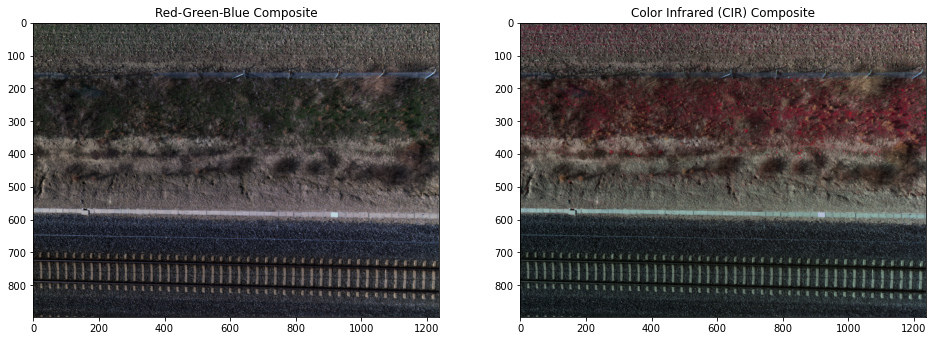

In [8]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [2,1,0]
cir_band_indices = [3,2,1]

# Create an empty normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],myCapture.num_bands+1), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,0:2].flatten(),  0.1)  # modify with these percentilse to adjust contrast
im_max = np.percentile(im_aligned[:,:,0:2].flatten(), 99.9)  # for many images, 0.5 and 99.5 are good values

for i in range(0,im_aligned.shape[2]):
    if img_type == 'reflectance':
        # for reflectance images we maintain white-balance by applying the same display scaling to all bands
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
    elif img_type == 'radiance':
        # for radiance images we do an auto white balance since we don't know the input light spectrum by
        # stretching each display band histogram to it's own min and max
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

rgb = im_display[:,:,rgb_band_indices]
# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

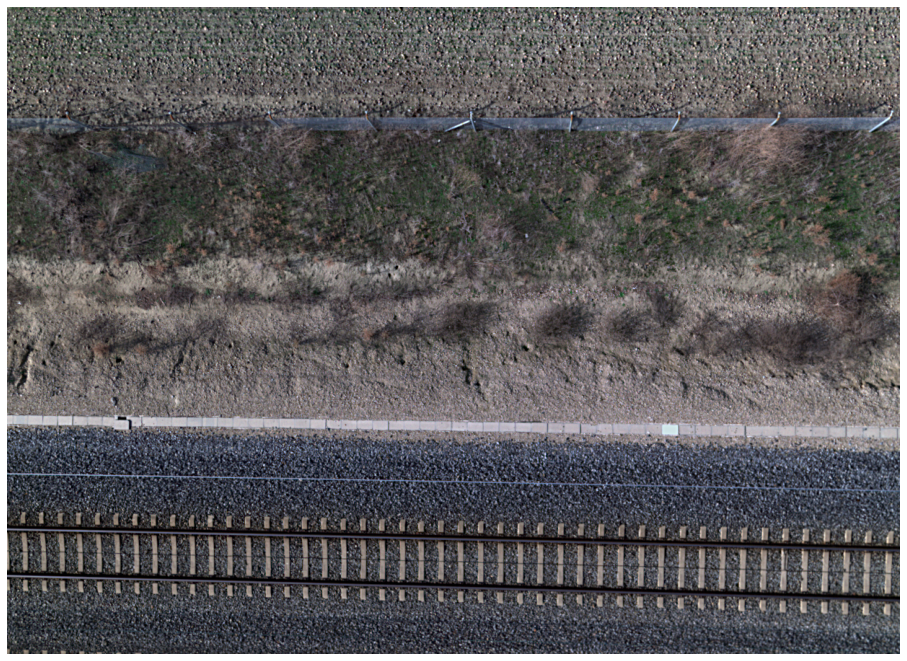

In [9]:
# Create an enhanced version of the RGB render using an unsharp mask
gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
gaussian_rgb[gaussian_rgb<0] = 0
gaussian_rgb[gaussian_rgb>1] = 1
unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
unsharp_rgb[unsharp_rgb<0] = 0
unsharp_rgb[unsharp_rgb>1] = 1

# Apply a gamma correction to make the render appear closer to what our eyes would see
gamma = 1.4
gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
fig = plt.figure(figsize=figsize)
plt.imshow(gamma_corr_rgb, aspect='equal')
plt.axis('off')
plt.show()

# compute NDVI

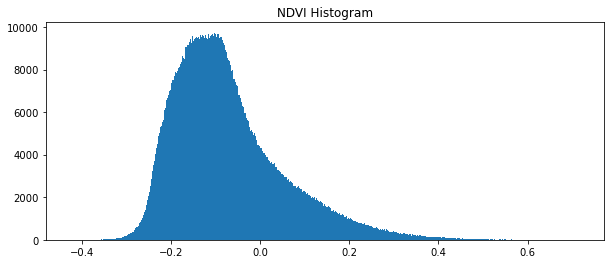

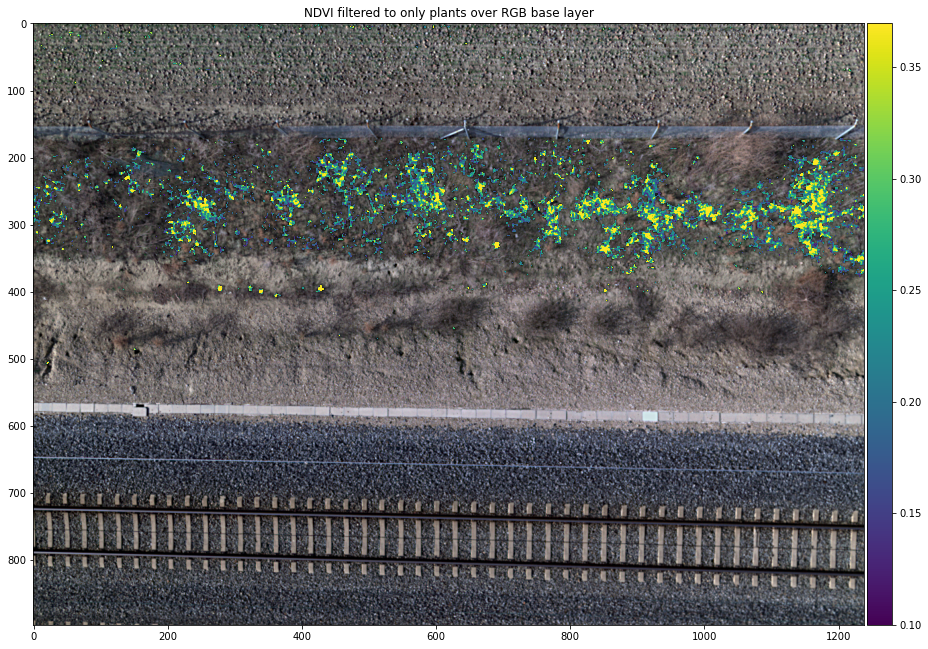

In [10]:
from micasense import plotutils
import matplotlib.pyplot as plt

threshold=0.1

nir_band = myCapture.band_names_lower().index('nir')
red_band = myCapture.band_names_lower().index('red')

np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

# Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])

# remove shadowed areas (mask pixels with NIR reflectance < 20%))
if img_type == 'reflectance':
    ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < 0.20, ndvi) 
elif img_type == 'radiance':
    lower_pct_radiance = np.percentile(im_aligned[:,:,3],  10.0)
    ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < lower_pct_radiance, ndvi) 
    
# Compute and display a histogram
ndvi_hist_min = np.min(ndvi)
ndvi_hist_max = np.max(ndvi)
fig, axis = plt.subplots(1, 1, figsize=(10,4))
axis.hist(ndvi.ravel(), bins=512, range=(ndvi_hist_min, ndvi_hist_max))
plt.title("NDVI Histogram")
plt.show()

min_display_ndvi = threshold # further mask soil by removing low-ndvi values
#min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
max_display_ndvi = np.percentile(ndvi.flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values
masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)

#reduce the figure size to account for colorbar
figsize=np.asarray(figsize) - np.array([3,2])

#plot NDVI over an RGB basemap, with a colorbar showing the NDVI scale
fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndvi, 
                                    figsize = figsize, 
                                    title = 'NDVI filtered to only plants over RGB base layer',
                                    vmin = min_display_ndvi,
                                    vmax = max_display_ndvi)
fig.savefig('ndvi_over_rgb.png')

# Create NDVI for a batch of images

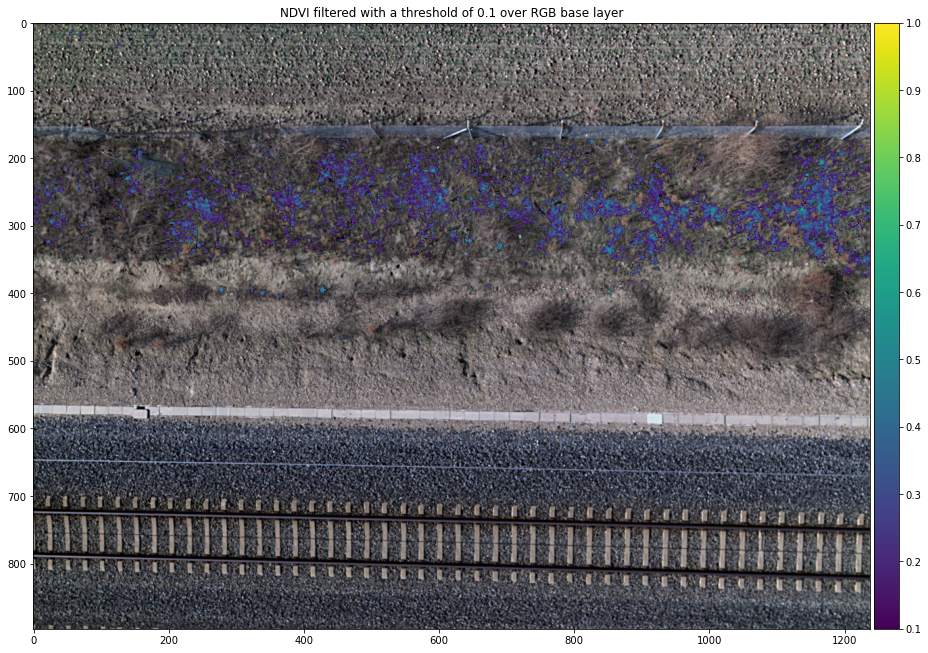

saving mydata/results_002/IMG_0557_ndvi_plot.png. 1/200


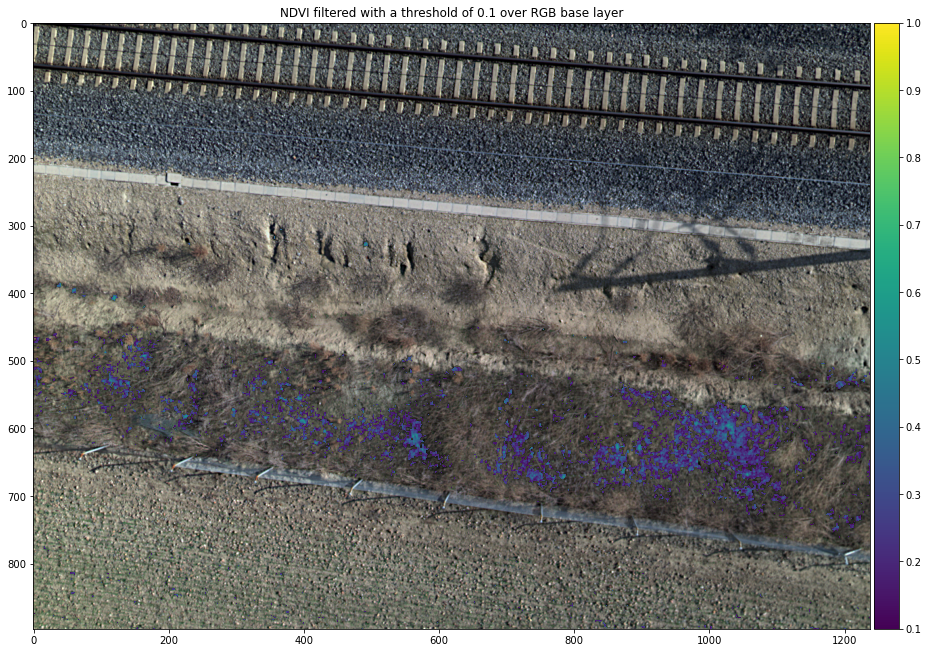

saving mydata/results_002/IMG_0417_ndvi_plot.png. 2/200


KeyboardInterrupt: 

In [11]:
imageNumbers=[imagePath.split("_")[2] for imagePath in imagePaths]
unique_imgs=list(set([imagePath.replace(imageNumber,"") for imagePath, imageNumber in zip(imagePaths, imageNumbers)]))
threshold=0.2
figsize=np.asarray([16,13])- np.array([3,2])  # use this size for export-sized display

for j,unique_img in enumerate(unique_imgs):
    imageNames=glob.glob(unique_img+"*")
    myCapture = capture.Capture.from_filelist(imageNames)
    cropped_dimensions, edges = imageutils.find_crop_bounds(myCapture, warp_matrices, warp_mode=warp_mode)
    im_aligned = imageutils.aligned_capture(myCapture, warp_matrices, warp_mode, cropped_dimensions,
                                            match_index, img_type=img_type)
    rgb_band_indices = [2,1,0]
    im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],myCapture.num_bands+1), dtype=np.float32 )
    for i in range(0,im_aligned.shape[2]):
        if img_type == 'reflectance':
            # for reflectance images we maintain white-balance by applying the same display scaling to all bands
            im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
        elif img_type == 'radiance':
            # for radiance images we do an auto white balance since we don't know the input light spectrum by
            # stretching each display band histogram to it's own min and max
            im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])
    rgb = im_display[:,:,rgb_band_indices]
    # Create an enhanced version of the RGB render using an unsharp mask
    gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
    gaussian_rgb[gaussian_rgb<0] = 0
    gaussian_rgb[gaussian_rgb>1] = 1
    unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
    unsharp_rgb[unsharp_rgb<0] = 0
    unsharp_rgb[unsharp_rgb>1] = 1

    # Apply a gamma correction to make the render appear closer to what our eyes would see
    gamma = 1.4
    gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
    threshold=0.1

    nir_band = myCapture.band_names_lower().index('nir')
    red_band = myCapture.band_names_lower().index('red')

    np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

    # Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
    ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])

    # remove shadowed areas (mask pixels with NIR reflectance < 20%))
    if img_type == 'reflectance':
        ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < 0.20, ndvi) 
    elif img_type == 'radiance':
        lower_pct_radiance = np.percentile(im_aligned[:,:,3],  10.0)
        ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < lower_pct_radiance, ndvi) 


    min_display_ndvi = threshold # further mask soil by removing low-ndvi values
    #min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
    #max_display_ndvi = np.percentile(ndvi.flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values
    max_display_ndvi=1
    masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)
    
    fig, _ = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndvi, 
                                    figsize = figsize, 
                                    title = 'NDVI filtered with a threshold of {} over RGB base layer'.format(threshold),
                                    vmin = min_display_ndvi,
                                    vmax = max_display_ndvi)
    fig.savefig(outputDir+unique_img.split(os.sep)[-1]+'ndvi_plot.png')
    print("saving {}. {}/{}".format(outputDir+unique_img.split(os.sep)[-1]+'ndvi_plot.png',j+1,len(unique_imgs)))
    

In [30]:
imageNumbers=[imagePath.split("_")[2] for imagePath in imagePaths]
unique_imgs=list(set([imagePath.replace(imageNumber,"") for imagePath, imageNumber in zip(imagePaths, imageNumbers)]))
figsize=np.asarray([16,13])- np.array([3,2])  # use this size for export-sized display

for j,unique_img in enumerate(unique_imgs):
    imageNames=glob.glob(unique_img+"*")
    myCapture = capture.Capture.from_filelist(imageNames)
    cropped_dimensions, edges = imageutils.find_crop_bounds(myCapture, warp_matrices, warp_mode=warp_mode)
    im_aligned = imageutils.aligned_capture(myCapture, warp_matrices, warp_mode, cropped_dimensions,
                                            match_index, img_type=img_type)
    rgb_band_indices = [2,1,0]
    im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],myCapture.num_bands+1), dtype=np.float32 )
    for i in range(0,im_aligned.shape[2]):
        if img_type == 'reflectance':
            # for reflectance images we maintain white-balance by applying the same display scaling to all bands
            im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
        elif img_type == 'radiance':
            # for radiance images we do an auto white balance since we don't know the input light spectrum by
            # stretching each display band histogram to it's own min and max
            im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])
    rgb = im_display[:,:,rgb_band_indices]
    # Create an enhanced version of the RGB render using an unsharp mask
    gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
    gaussian_rgb[gaussian_rgb<0] = 0
    gaussian_rgb[gaussian_rgb>1] = 1
    unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
    unsharp_rgb[unsharp_rgb<0] = 0
    unsharp_rgb[unsharp_rgb>1] = 1

    # Apply a gamma correction to make the render appear closer to what our eyes would see
    gamma = 1.4
    gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
    nir_band = myCapture.band_names_lower().index('nir')
    red_band = myCapture.band_names_lower().index('red')

    np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

    # Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
    ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])

    # remove shadowed areas (mask pixels with NIR reflectance < 20%))
    if img_type == 'reflectance':
        ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < 0.20, ndvi) 
    elif img_type == 'radiance':
        lower_pct_radiance = np.percentile(im_aligned[:,:,3],  10.0)
        ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < lower_pct_radiance, ndvi) 

    min_display_ndvi = 0.2 # further mask soil by removing low-ndvi values
    #min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
    max_display_ndvi = 1  # for many images, 0.5 and 99.5 are good values
    masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)
    #masked_ndvi = np.ma.masked_where(masked_ndvi > max_display_ndvi, ndvi)
    masked_ndvi[masked_ndvi!=0]=(masked_ndvi[masked_ndvi!=0]-min_display_ndvi)/(max_display_ndvi-min_display_ndvi)
 
    cmap = plt.get_cmap('viridis')
    masked_ndvi_rgb=cmap(masked_ndvi)
    masked_ndvi_rgb = np.delete(masked_ndvi_rgb, 3, 2)
    green_mask= np.where(masked_ndvi_rgb==(0,0,0),(0,0,0),(0,1,0))
    cv2.imwrite(outputDir+unique_img.split(os.sep)[-1]+'ndvi_over_rgb.png',
                np.where(masked_ndvi_rgb!=(0,0,0),masked_ndvi_rgb,gamma_corr_rgb)[:,:,::-1]*255)
    cv2.imwrite(outputDir+unique_img.split(os.sep)[-1]+'ndvi_only.png',
                masked_ndvi_rgb[:,:,::-1]*255)
    cv2.imwrite(outputDir+unique_img.split(os.sep)[-1]+'green_where_ndvi.png',
                np.where(green_mask!=(0,0,0),green_mask,gamma_corr_rgb)[:,:,::-1]*255)
    
    print("saving {}. {}/{}".format(outputDir+unique_img.split(os.sep)[-1]+'ndvi.png',j+1,len(unique_imgs)))
    

saving mydata/results_002/IMG_0557_ndvi.png. 1/200
saving mydata/results_002/IMG_0417_ndvi.png. 2/200
saving mydata/results_002/IMG_0449_ndvi.png. 3/200
saving mydata/results_002/IMG_0516_ndvi.png. 4/200
saving mydata/results_002/IMG_0570_ndvi.png. 5/200
saving mydata/results_002/IMG_0542_ndvi.png. 6/200
saving mydata/results_002/IMG_0451_ndvi.png. 7/200
saving mydata/results_002/IMG_0568_ndvi.png. 8/200
saving mydata/results_002/IMG_0457_ndvi.png. 9/200
saving mydata/results_002/IMG_0498_ndvi.png. 10/200
saving mydata/results_002/IMG_0537_ndvi.png. 11/200
saving mydata/results_002/IMG_0561_ndvi.png. 12/200
saving mydata/results_002/IMG_0538_ndvi.png. 13/200
saving mydata/results_002/IMG_0560_ndvi.png. 14/200
saving mydata/results_002/IMG_0489_ndvi.png. 15/200
saving mydata/results_002/IMG_0587_ndvi.png. 16/200
saving mydata/results_002/IMG_0422_ndvi.png. 17/200
saving mydata/results_002/IMG_0491_ndvi.png. 18/200
saving mydata/results_002/IMG_0445_ndvi.png. 19/200
saving mydata/results

saving mydata/results_002/IMG_0581_ndvi.png. 158/200
saving mydata/results_002/IMG_0588_ndvi.png. 159/200
saving mydata/results_002/IMG_0526_ndvi.png. 160/200
saving mydata/results_002/IMG_0532_ndvi.png. 161/200
saving mydata/results_002/IMG_0400_ndvi.png. 162/200
saving mydata/results_002/IMG_0533_ndvi.png. 163/200
saving mydata/results_002/IMG_0495_ndvi.png. 164/200
saving mydata/results_002/IMG_0507_ndvi.png. 165/200
saving mydata/results_002/IMG_0477_ndvi.png. 166/200
saving mydata/results_002/IMG_0444_ndvi.png. 167/200
saving mydata/results_002/IMG_0510_ndvi.png. 168/200
saving mydata/results_002/IMG_0461_ndvi.png. 169/200
saving mydata/results_002/IMG_0460_ndvi.png. 170/200
saving mydata/results_002/IMG_0494_ndvi.png. 171/200
saving mydata/results_002/IMG_0558_ndvi.png. 172/200
saving mydata/results_002/IMG_0530_ndvi.png. 173/200
saving mydata/results_002/IMG_0578_ndvi.png. 174/200
saving mydata/results_002/IMG_0407_ndvi.png. 175/200
saving mydata/results_002/IMG_0402_ndvi.png. 1

In [27]:
def resize(image,ratio):
    H=int(image.shape[0]/ratio)
    W=int(image.shape[1]/ratio)
    return cv2.resize(image,(W,H))

In [28]:
stitcher  = cv2.Stitcher_create()
images_to_stitch_paths=glob.glob(outputDir+"*no_bar*")
images_to_stitch_paths.sort()
images_to_stitch=[resize(cv2.imread(image_to_stich_path),5) for image_to_stich_path in images_to_stitch_paths ]

In [29]:
(status, stitched) = stitcher.stitch(images_to_stitch[0:20])
if not status:
    pilimg=PIL.Image.fromarray(stitched.astype("uint8"))   
    pilimg.show()
else:
    print(status)

1


In [30]:
PIL.Image.fromarray(stitched.astype("uint8"))

AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
cv2.imwrite(outputDir+"panoramica.png",stitched[:,:,::-1])